In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import zlib, base64
from scipy import signal
import os
import shutil
import json

In [1]:
 def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.fromstring(z, np.uint8)
    mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

In [2]:
def load_mask(path, image):
    with open(path,'r') as file:
        data = json.load(file)

    code = data["objects"][0]["bitmap"]["data"]
    origin = data["objects"][0]["bitmap"]["origin"]
    mask = base64_2_mask(code)
    mask_center = np.array([mask.shape[1]/2, mask.shape[0]/2])
    mask_center += origin

    up = np.zeros((origin[1],mask.shape[1]))
    mask2 = np.vstack((up,mask))
    left = np.zeros((mask2.shape[0], origin[0]))
    mask3 = np.hstack((left,mask2))
    down = np.zeros((image.shape[0]-mask3.shape[0],mask3.shape[1]))
    mask4 = np.vstack((mask3,down))
    right = np.zeros((mask4.shape[0],image.shape[1]-mask4.shape[1]))
    mask5 = np.hstack((mask4,right))
    
    return mask5.astype('uint8'), mask_center.astype(int)

In [4]:
def find_cross(part, houghlinePara=50):
    edge = cv.Canny(part, 0,1)
    lines = cv.HoughLines(edge, 1, np.pi / 180, houghlinePara)
    
    rhos = []
    thetas = []
    for line in lines:
        rho, theta = line[0]
        rhos.append(rho)
        thetas.append(theta)
    
    thetas = np.array(thetas)
    rhos = np.array(rhos)
    mean = np.mean(thetas)
    inx = thetas > mean

    thetas1 = thetas[inx]
    rhos1 = rhos[inx]
    thetas2 = thetas[1-inx!=0]
    rhos2 = rhos[1-inx!=0]
    #detect outliers
    inx2 = np.abs(rhos1-np.mean(rhos1)) <= np.std(rhos1)
    rhos1 = rhos1[inx2]
    thetas1 = thetas1[inx2]
    inx3 = np.abs(rhos2-np.mean(rhos2)) <= np.std(rhos2)
    rhos2 = rhos2[inx3]
    thetas2 = thetas2[inx3]
    
    theta1 = np.mean(thetas1)
    rho1 = np.mean(rhos1)
    theta2 = np.mean(thetas2)
    rho2 = np.mean(rhos2)

    k1 = -1/np.tan(theta1)
    k2 = -1/np.tan(theta2)
    b1 = rho1*np.sin(theta1)-k1*rho1*np.cos(theta1)
    b2 = rho2*np.sin(theta2)-k2*rho2*np.cos(theta2)

    x_cross = (b2-b1)/(k1-k2)
    y_cross = (k1*b2-k2*b1)/(k1-k2)
    #return thetas1, thetas2
    return x_cross, y_cross

In [5]:
def find_module_corner(mask, mask_center, dist=200, displace=0, method=0, corner_center=False, center_displace=10):
    x_m = mask_center[0]
    y_m = mask_center[1]

    if corner_center:
        corners = cv.goodFeaturesToTrack(mask, 4, 0.01, 200, blockSize=9)
        corners = np.int0(corners)
        xs1 = []
        ys1 = []
        for i in corners:
            x, y = i.ravel()
            xs1.append(x)
            ys1.append(y)
        x_m = int(np.mean(xs1))
        y_m = int(np.mean(ys1))
    
 
    A = mask[0:y_m+center_displace, 0:x_m+center_displace]
    B = mask[0:y_m+center_displace, x_m-center_displace:]
    C = mask[y_m-center_displace:, 0:x_m+center_displace]
    D = mask[y_m-center_displace:, x_m-center_displace:]
    #A, B = np.hsplit(mask,2)
    #A, C = np.vsplit(A,2)
    #B, D = np.vsplit(B,2)
    xs = []
    ys = []
    if method == 0:
        
        corners_A = cv.goodFeaturesToTrack(A, 1, 0.01, dist, blockSize=9)
        corners_A = np.int0(corners_A)
        corners_B = cv.goodFeaturesToTrack(B, 1, 0.01, dist, blockSize=9)
        corners_B = np.int0(corners_B)
        corners_C = cv.goodFeaturesToTrack(C, 1, 0.01, dist, blockSize=9)
        corners_C = np.int0(corners_C)
        corners_D = cv.goodFeaturesToTrack(D, 1, 0.01, dist, blockSize=9)
        corners_D = np.int0(corners_D)


        for corners in [corners_A, corners_B, corners_C, corners_D]:
            for i in corners:
                x, y = i.ravel()
                xs.append(x)
                ys.append(y)
    
    if method == 1:
        for part in [A,B,C,D]:
            x_cross, y_cross = find_cross(part)
            xs.append(x_cross)
            ys.append(y_cross)
    
    #for i in corners_y:
     #   x, y = i.ravel()
      #  xs.append(x+A.shape[1])
       # ys.append(y)
    #sort out the corners    
    xs[1] += x_m-center_displace
    ys[2] += y_m-center_displace
    xs[3] += x_m-center_displace
    ys[3] += y_m-center_displace
    
    #xs = np.array(xs)
    #ys = np.array(ys)
    #x_avg = np.average(xs)
    #y_avg = np.average(ys)
    xs[0] -= displace
    ys[0] -= displace

    xs[1] += displace
    ys[1] -= displace

    xs[2] -= displace
    ys[2] += displace

    xs[3] += displace
    ys[3] += displace

    corners_order = list(zip(xs,ys))

    """
    corners_order = []

    for y_coeff in [-1,1]:
        for x_coeff in [-1,1]:
            if y_coeff == -1:
                y_comp = (ys < y_avg)
            else:
                y_comp = (ys > y_avg)
            if x_coeff == -1:
                x_comp = (xs < x_avg)
            else:
                x_comp = (xs > x_avg)
                        
            x_inx=np.argwhere(x_comp)
            y_inx=np.argwhere(y_comp)
            corners_order.append((xs[int(np.intersect1d(x_inx,y_inx))]+ x_coeff*displace,
                                  ys[int(np.intersect1d(x_inx,y_inx))]+ y_coeff*displace))
    """
    return np.array(corners_order)
    

In [6]:
def perspective_transform(image, src, sizex, sizey):
    src = np.float32(src)
    dst = np.float32([(0, 0), (sizex, 0), (0, sizey), (sizex, sizey)])
    M = cv.getPerspectiveTransform(src, dst)

    warped = cv.warpPerspective(image,M,(sizex,sizey))

    return warped

In [7]:
def find_cell_corner(wrap, dist=25):
    wrap_g = cv.cvtColor(wrap, cv.COLOR_BGR2GRAY)
    
    sum_x = np.sum(wrap_g, axis=0)
    sum_x = sum_x / np.max(sum_x)
    peak_x, _ = signal.find_peaks(-sum_x, distance=dist, prominence=0.08)
    
    sum_y = np.sum(wrap_g, axis=1)
    sum_y = sum_y / np.max(sum_y)
    peak_y, _ = signal.find_peaks(-sum_y, distance=dist, prominence=0.08)

    return peak_x, peak_y

In [8]:
def find_corner_mean(wrap, x, y, displace=7):
    try:
        x_l = x - displace
        x_r = x + displace
        y_u = y - displace
        y_d = y + displace

        xs = [x_l,x_r,x_l,x_r]
        ys = [y_u,y_u,y_d,y_d]
        crop = perspective_transform(wrap, list(zip(xs,ys)), displace*2, displace*2)
        crop_g = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)

        corners = cv.goodFeaturesToTrack(crop_g, 4, 0.01, 1)
        corners = np.int0(corners)
        points_x = []
        points_y = []

        for i in corners:
            x_c, y_c = i.ravel()
            points_x.append(x_c)
            points_y.append(y_c)

        x_mean = np.mean(points_x)
        y_mean = np.mean(points_y)
        x_mean += x_l
        y_mean += y_u
    except:
        return x, y
    else:
        return x_mean, y_mean

In [9]:
def crop_cell(wrap, peak_x, peak_y, saveplace, plot_bool=0, data_bool=0):
    if plot_bool:
        plt.imshow(cv.cvtColor(wrap, cv.COLOR_BGR2RGB))
    
    data = []
    #n = 0
    for i in range(len(peak_x)+1):
        if i == 0:
            x_l = 0
            x_r = peak_x[i]
        elif i == len(peak_x):
            x_l = peak_x[i-1]
            x_r = wrap.shape[1]
        else: 
            x_l = peak_x[i-1]
            x_r = peak_x[i]

        for j in range(len(peak_y)+1):
            if j == 0:
                y_u = 0
                y_d = peak_y[j]
            elif j == len(peak_y):
                y_u = peak_y[j-1]
                y_d = wrap.shape[0]
            else: 
                y_u = peak_y[j-1]
                y_d = peak_y[j]
            xs = []
            ys = []
            for y_c in [y_u, y_d]:
                for x_c in [x_l, x_r]:
                    x_mean, y_mean = find_corner_mean(wrap, x_c, y_c)
                    
                    xs.append(x_mean)
                    ys.append(y_mean)
            if plot_bool:
                plt.scatter(xs,ys)
            if data_bool:
                data.append(list(zip(xs,ys)))
            
            crop = perspective_transform(wrap, list(zip(xs,ys)), 64, 64)
            #cv.imwrite(saveplace+str(i)+"_"+str(j)+".png", crop)
            #n += 1
    if data_bool:
        return np.array(data)
    

# Explanation on the codes

## load the annotations and images

In [385]:
filepaths = os.listdir('img/')
filepaths[1]

'1-3-A8CB1-111-09_21_09_13_20.png'

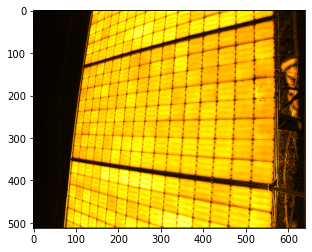

In [398]:
path = filepaths[1]
name = path.split('.')[0]

image = cv.imread('img/'+name+'.png' )
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

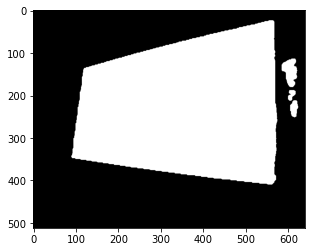

In [399]:
mask, mask_center = load_mask('ann/'+name+'.png.json', image)
plt.imshow(mask, "gray")

## detect corners

you can use different methods by varying 'method'. Method 0 uses corner_detection function from opencv and methd 1 uses houghline tranfrom from opencv. 

If 'corner_center' is 'on', then the tool will define the initial corner center as the center of the whole image, otherwie it will define the center as the center of initial four corners of the mask. When 'corner_center' is on, we recommend 'center_displace=50', otherwise leave it as default.

In [400]:
# this is a example of using method1 with corner_center on.
corners = find_module_corner(mask, mask_center, method=1, displace=3, corner_center=True, center_displace=50)
corners

array([[115.39713316, 131.76093266],
       [570.75406975, 140.96469554],
       [ 86.59670976, 350.7123326 ],
       [572.82603689, 416.0233079 ]])

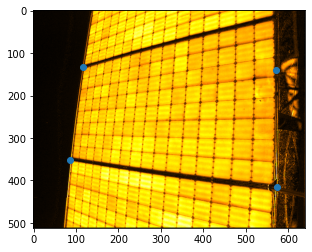

In [401]:
# Unfortunately the result looks bad. We can try other methods
xs, ys = list(zip(*corners))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.scatter(xs,ys)

## perspective transform

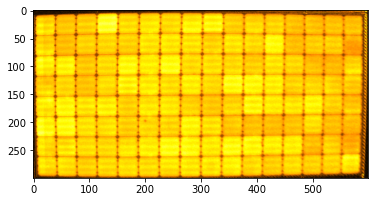

In [390]:
wrap = perspective_transform(image, corners, 600, 300)
plt.imshow(cv.cvtColor(wrap, cv.COLOR_BGR2RGB))

## detect the inner edges

In [391]:
peak_x, peak_y = find_cell_corner(wrap)

In [393]:
len(peak_y)

7

In [213]:
wrap_g = cv.cvtColor(wrap, cv.COLOR_BGR2GRAY)
    
sum_x = np.sum(wrap_g, axis=0)
sum_x = sum_x / np.max(sum_x)
peak_x, _ = signal.find_peaks(-sum_x, distance=25, prominence=0.08)

sum_y = np.sum(wrap_g, axis=1)
sum_y = sum_y / np.max(sum_y)
peak_y, _ = signal.find_peaks(-sum_y, distance=25, prominence=0.08)

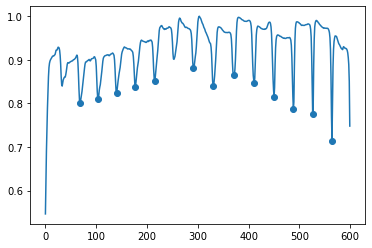

In [214]:
plt.plot(range(len(sum_x)),sum_x)
plt.scatter(peak_x,sum_x[peak_x])

## crop out the single cells

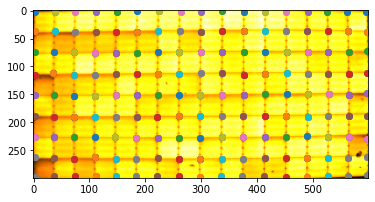

In [21]:
crop_cell(wrap, peak_x, peak_y, saveplace="crop/", plot_bool=1)

# Now do the segment on all the solar modules

In [10]:
filepaths = os.listdir('../../upload2/')

In [11]:
if '.DS_Store' in filepaths:
    filepaths.remove('.DS_Store')


In [12]:
name = filepaths[0].split('.')[0]
path = 'ann/'+name+'.png.json'

In [13]:
name, path

('1-2-A7CB3-32-09_15_16_59_20', 'ann/1-2-A7CB3-32-09_15_16_59_20.png.json')

In [14]:
N = 0
N_err = 0
for file in filepaths:
    N += 1
    try:
        name = file.split('.')[0]
        path = 'ann/'+name+'.png.json'
        image = cv.imread('../../upload2/'+name+'.png')

        mask, mask_center = load_mask(path, image)
        corners = find_module_corner(mask, mask_center, method=0, displace=3)
        wrap = perspective_transform(image, corners, 600, 300)
        peak_x, peak_y = find_cell_corner(wrap)
        if len(peak_x) > 12 and len(peak_y) > 5:
            #cv.imwrite("temp_transform/"+name+".png", wrap)
            pass
        else:
            #print(name + " trying method2")
            corners = find_module_corner(mask, mask_center, method=1, displace=3)
            wrap = perspective_transform(image, corners, 600, 300)
            peak_x, peak_y = find_cell_corner(wrap)
            if len(peak_x) > 12 and len(peak_y) > 5:
                #cv.imwrite("temp_transform/"+name+".png", wrap)
                pass
            else: 
                corners = find_module_corner(mask, mask_center, method=1, displace=3, corner_center=True, center_displace=50)
                wrap = perspective_transform(image, corners, 600, 300)
                peak_x, peak_y = find_cell_corner(wrap)
                if len(peak_x) > 12 and len(peak_y) > 5:
                    #cv.imwrite("temp_transform/"+name+".png", wrap)
                    pass
                else:
                    corners = find_module_corner(mask, mask_center, method=0, displace=3, corner_center=True, center_displace=50)
                    wrap = perspective_transform(image, corners, 600, 300)
                    peak_x, peak_y = find_cell_corner(wrap)
                    if len(peak_x) > 12 and len(peak_y) > 5:
                        #cv.imwrite("temp_transform/"+name+".png", wrap)
                        pass
                    else:
                        N_err+=1
                        #print(name+" seg error")
                        #with open("error2.csv",'a') as f:
                        #    f.write(name+'.png\n')
                        #shutil.copyfile('img/'+name+'.png', 'error_all/'+name+'.png')
        
    except:
        #print(name+" run error")
        N_err += 1
        #with open("error2.csv",'a') as f:
        #    f.write(name+'.png\n')
        #shutil.copyfile('img/'+name+'.png', 'error_all/'+name+'.png')

print("total images: "+str(N))
print("failed images:"+ str(N_err))
print("accuracy: " + str(1-N_err/N))

total images: 9584
failed images:333
accuracy: 0.965254590984975
